In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
from sklearn.datasets import fetch_openml
import numpy as np

In [80]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [81]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [82]:
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist)

In [83]:
X, y = mnist["data"], mnist["target"]

In [84]:
X.shape

(70000, 784)

In [85]:
y.shape

(70000,)

In [86]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [87]:
some_digits = X[36000]
some_digits_image = some_digits.reshape(28,28)

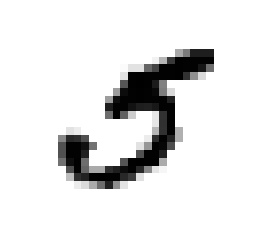

In [88]:
plt.imshow(some_digits_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [89]:
y[36000]

5

In [90]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [91]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [92]:
y_train_5 = (y_train == 5)
y_train_5

array([False, False,  True, ..., False, False, False])

In [93]:
y_test_5 = (y_test == 5)
y_test_5

array([False, False, False, ..., False, False, False])

In [94]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [95]:
sgd_clf.predict([some_digits])

array([ True])

# Cross-Validation

In [96]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.961
0.9613
0.96325


In [97]:
from sklearn.model_selection import cross_val_score

In [98]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.961  , 0.9613 , 0.96325])

## Accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

In [99]:
from sklearn.base import BaseEstimator
import numpy as np

In [100]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [101]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")    # score

array([0.9098 , 0.91065, 0.9085 ])

# Confusion Matrix

In [102]:
from sklearn.model_selection import cross_val_predict

In [103]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)      # predict
y_train_pred

array([False, False,  True, ..., False, False, False])

In [104]:
from sklearn.metrics import confusion_matrix

In [105]:
confusion_matrix(y_train_5, y_train_pred)

array([[53743,   836],
       [ 1453,  3968]])

In [106]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# Precision and Recall

In [107]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8259783513738551

In [108]:
recall_score(y_train_5, y_train_pred)

0.7319682715366168

In [109]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7761369193154034

In [110]:
y_scores = sgd_clf.decision_function([some_digits])
y_scores

array([21782.76123872])

In [111]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [112]:
sgd_clf.predict([some_digits])

array([ True])

In [113]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### ==> Rasing the threshold decreases recall. 

In [114]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [115]:
y_scores

array([-919646.01087668, -735485.89067708,  273030.02233739, ...,
       -268675.28670333, -548619.91329351, -652840.73031249])

## Compute precision and recall for all possible thresholds.

In [116]:
from sklearn.metrics import precision_recall_curve

In [117]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [118]:
precisions.shape

(59809,)

In [119]:
recalls.shape

(59809,)

In [120]:
thresholds.shape

(59808,)

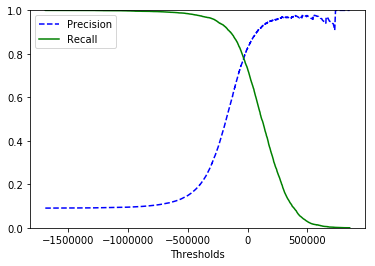

In [121]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Thresholds")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

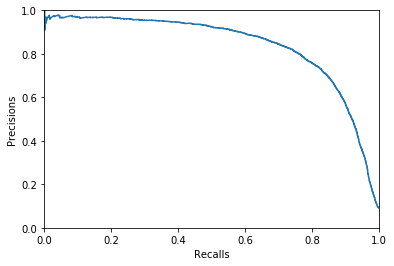

In [122]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recalls")
    plt.ylabel("Precisions")
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [123]:
y_train_pred_90 = (y_scores > 70000)
y_train_pred_90

array([False, False,  True, ..., False, False, False])

In [124]:
precision_score(y_train_5, y_train_pred_90)

0.8926909389542842

In [125]:
recall_score(y_train_5, y_train_pred_90)

0.6015495296070835

# The ROC Curve
The receiver operating characteristic.

In [126]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [127]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99648216, 0.99648216,
       1.        ])

In [128]:
tpr

array([0.00000000e+00, 1.84467810e-04, 1.84467810e-03, ...,
       9.99815532e-01, 1.00000000e+00, 1.00000000e+00])

In [129]:
thresholds

array([  855891.84033426,   855890.84033426,   737383.97434709, ...,
       -1693128.86402518, -1694149.44329113, -2836872.79017343])

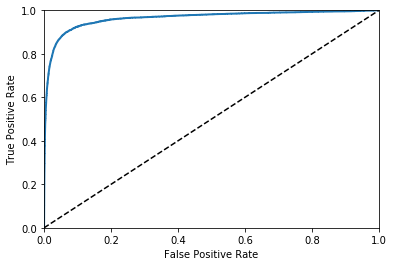

In [130]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

$ TPR=\frac{TP}{TP+FN} $

$ FPR=\frac{FP}{FP+TN} $

## Area Under the Curve (AUC)
A prefect classifier will have a ROC AUC equal to 1.

In [131]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9638915761082284

## RandomForest with AUC

In [132]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [133]:
y_probas_forest

array([[1. , 0. ],
       [1. , 0. ],
       [0.1, 0.9],
       ...,
       [0.9, 0.1],
       [1. , 0. ],
       [0.9, 0.1]])

In [135]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0. , 0. , 0.9, ..., 0.1, 0. , 0.1])

In [136]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

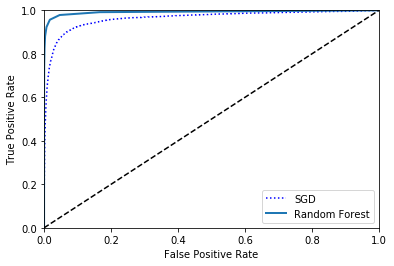

In [140]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [142]:
roc_auc_score(y_train_5, y_scores_forest)

0.9922183795906674

# Multiclass Classfication

In [143]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [144]:
sgd_clf.predict([some_digits])

array([5], dtype=int8)

In [145]:
some_digit_scores = sgd_clf.decision_function([some_digits])
some_digit_scores

array([[-353486.53323486, -368245.70059993, -429180.21123419,
        -181088.66145845, -458842.44653938,   21782.76123872,
        -627215.05821825, -272517.14994828, -438372.75128706,
        -439239.92503978]])

In [149]:
np.argmax(some_digit_scores)

5

In [150]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [154]:
sgd_clf.classes_[5]

5

### OvO strategy, based on a SGDClassifier

In [155]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digits])

array([5], dtype=int8)

In [156]:
len(ovo_clf.estimators_)

45

Random Forest classifiers can directly classify instances into multiple classed.

In [157]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digits])

array([5], dtype=int8)

In [158]:
forest_clf.predict_proba([some_digits])

array([[0. , 0. , 0. , 0.1, 0.1, 0.8, 0. , 0. , 0. , 0. ]])

cross_val_score

In [159]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85052989, 0.85234262, 0.85657849])

In [160]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9405119 , 0.94019701, 0.94234135])

In [161]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.91346731, 0.91319566, 0.91638746])

Scaling the inputs increases accuracy above 90%.

In [163]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90876825, 0.90859543, 0.91143672])

# Error Analysis

In [164]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [165]:
y_train_pred

array([9, 8, 5, ..., 9, 3, 9], dtype=int8)

In [166]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    2,   22,    9,   12,   49,   45,    6,   40,    4],
       [   1, 6481,   44,   30,    6,   46,    9,   11,  105,    9],
       [  57,   34, 5336,  109,   81,   26,   91,   53,  159,   12],
       [  43,   37,  134, 5366,    4,  221,   36,   55,  141,   94],
       [  21,   31,   44,    9, 5359,   12,   50,   24,   79,  213],
       [  67,   39,   34,  178,   73, 4638,  106,   24,  170,   92],
       [  32,   26,   47,    2,   46,  107, 5609,    3,   45,    1],
       [  21,   22,   69,   30,   59,   11,    7, 5773,   16,  257],
       [  49,  161,   72,  156,   17,  180,   57,   25, 4996,  138],
       [  40,   34,   29,   88,  155,   41,    2,  195,   81, 5284]])

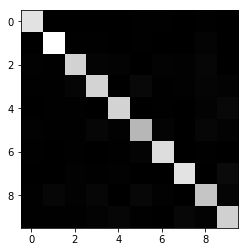

In [168]:
plt.imshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Compare error rate instead of absolute numbers of errors.
+ Rows represent actual classes;
+ Columns represent predicted classes.

In [175]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

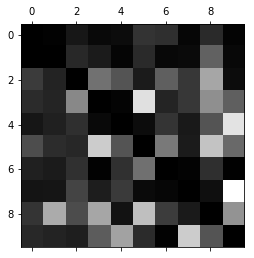

In [177]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_